In [1]:
import gammapy
print(gammapy.__version__ , " == 1")

0.1.dev19174+g56b5bdf  == 1


In [2]:
import numpy as np
import os
import astropy
from astropy import units as u
import matplotlib.pyplot as plt

from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from collections import OrderedDict
from astropy import units
from gammapy.data import DataStore
from astropy.io import fits
from astropy.coordinates import SkyCoord
from gammapy.data import FixedPointingInfo, Observation, DataStore, observatory_locations
from astropy.coordinates import SkyOffsetFrame
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.datasets import MapDataset
from gammapy.irf import load_cta_irfs, EDispKernel, PSFKernel
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    FoVBackgroundModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    GaussianSpatialModel
)
from regions import CircleSkyRegion, RectangleSkyRegion


In [3]:
pks_pos = SkyCoord(frame = "galactic",l =  "17.74 deg", b= "-52.25 deg")
pks_pos = SkyCoord("21h58m43.2s", "-30d13m18s")


In [4]:
try:
    models  = Models.read('../standard_model.yml')
except:
    st_model = SkyModel(spatial_model = PointSpatialModel(lon_0 = pks_pos.l.deg *u.deg, lat_0 =  pks_pos.b.deg * u.deg),
                       spectral_model = PowerLawSpectralModel())
    Models(st_model).write("../standard_model.yml")
    models  = Models.read('../standard_model.yml')
    

In [5]:
dataset_public = MapDataset.read('dataset-stacked.fits.gz')
empty = dataset_public.copy()


path = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/pks2155_flare/out'
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
observations = data_store.get_observations(data_store.obs_ids)


In [6]:
dataset_simulated = MapDataset.read('dataset-simulated-100.0-hr.fits.gz')
emask = dataset_simulated.mask.data.sum(axis=2).sum(axis=1) >0
emask = dataset_simulated.mask.geom.axes[0].center[emask]

## IRF plots

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:343: GammapyDeprecationWarning: obs_info property is deprecated since v1.2. Use meta instead.
  warnings.warn(


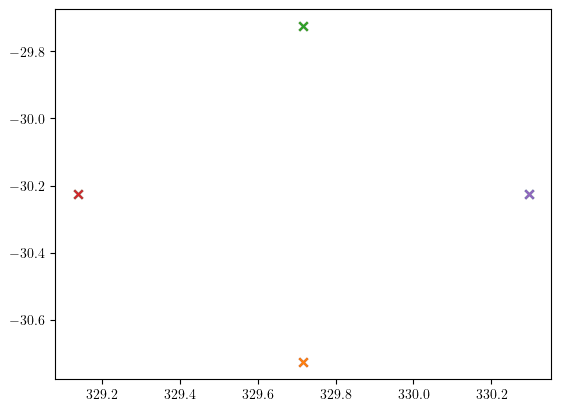

In [7]:
path = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/pks2155_flare/out'
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
observations = data_store.get_observations(data_store.obs_ids)



ra_pnt, dec_pnt = [], []
for obs in observations:
    ra_pnt.append(obs.obs_info['RA_PNT'])
    dec_pnt.append(obs.obs_info['DEC_PNT'])
    
fig, ax = plt.subplots(1,1)
for i in range(len(observations)):
    plt.scatter(ra_pnt[i], dec_pnt[i], marker = 'x')

In [8]:
dataset_simulated.exposure.geom.center_skydir

<SkyCoord (ICRS): (ra, dec) in deg
    (329.72244675, -30.22026042)>

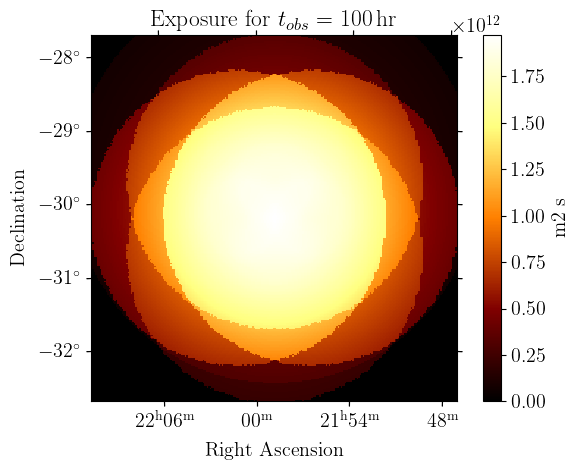

In [9]:
fig = plt.figure( )
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
dataset_simulated.exposure.cutout(dataset_simulated.exposure.geom.center_skydir, 5*u.deg).sum_over_axes().plot(add_cbar = 1);

ax = plt.gca()
fig = plt.gcf()
ax.set_title("Exposure for $t_{obs}$ $ = 100\,$hr", fontsize = 17)

plt.tight_layout()
fig.savefig("plots/3-exposure.pdf")
fig.savefig("plots/3-exposure.svg")
fig.savefig("plots/3-exposure.png")

In [10]:
dataset_simulated.psf.containment_radius(0.68, 1*u.TeV)

<Quantity [0.09825] deg>

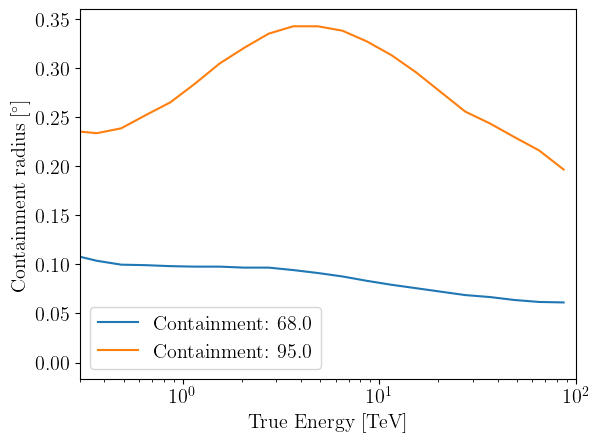

In [11]:
ax = dataset_simulated.psf.plot_containment_radius_vs_energy(  )
fig = plt.gcf()
ax.set_xlim(0.3, 100)
fig.savefig("plots/3-psf.pdf")
fig.savefig("plots/3-psf.svg")
fig.savefig("plots/3-psf.png")

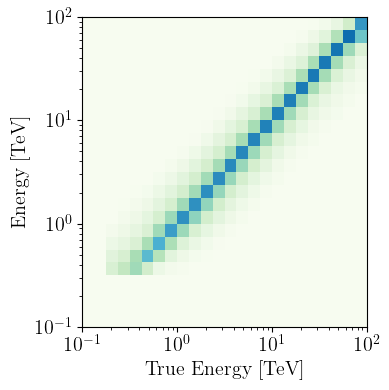

In [12]:
fig, ax = plt.subplots(1,1, figsize= (4,4))
edisp = dataset_simulated.edisp.get_edisp_kernel()
edisp.plot_matrix(ax =ax)
plt.tight_layout()

fig.savefig("plots/3-edisp.pdf")
fig.savefig("plots/3-edisp.svg")
fig.savefig("plots/3-edisp.png")

## Creating the models

In [13]:
import operator
from gammapy.modeling.models import (
    PointSpatialModel,
    PowerLawSpectralModel, 
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    GaussianSpectralModel,
    CompoundSpectralModel,
    SkyModel
)

In [14]:
spatial_model = PointSpatialModel(lon_0 = pks_pos.ra, 
                                  lat_0 = pks_pos.dec,
                                  frame= 'icrs')

spatial_model.parameters['lon_0'].max = spatial_model.parameters['lon_0'].value + 1
spatial_model.parameters['lon_0'].min = spatial_model.parameters['lon_0'].value - 1
spatial_model.parameters['lat_0'].max = spatial_model.parameters['lat_0'].value + 1
spatial_model.parameters['lat_0'].min = spatial_model.parameters['lat_0'].value - 1

pks_par = dict()
# https://www.aanda.org/articles/aa/pdf/2005/06/aa1853.pdf
# Time-averaged spectrum
factor  = 1 *u.Unit("m-2").to("cm-2")
a = {'value':4.0e-8*factor, 'error':1.9e-8*factor}
pks_par['amplitude'] = a
index = {'value':3.32, 'error':0.06}
pks_par['index'] = index
ecut = {'value':1.4, 'error':0.8}
lambda_ = {'value':1/ecut['value'], 'error': ecut['error']/ (ecut['value'] **2 )}
pks_par['lambda_'] = lambda_

reference = {'value':1, 'error':0.}
pks_par['reference'] = reference
alpha = {'value':1, 'error':0.}
pks_par['alpha'] = alpha

pkscutoff_model = ExpCutoffPowerLawSpectralModel()
for par in pkscutoff_model.parameters:
    par.value = pks_par[par.name]['value']
    par.error = pks_par[par.name]['error']

    
    
crab_par = dict()
# https://arxiv.org/pdf/1509.02902.pdf
a = {'value':1.79e-10, 'error':0.03e-10}
crab_par['amplitude'] = a
alpha = {'value':2.10, 'error':0.04}
crab_par['alpha'] = alpha
beta = {'value':0.24, 'error':0.01}
crab_par['beta'] = beta
reference = {'value':0.521, 'error':0.0}
crab_par['reference'] = reference
logparabola_model = LogParabolaSpectralModel()
for par in logparabola_model.parameters:
    par.value = crab_par[par.name]['value']
    par.error = crab_par[par.name]['error']

scale = 1
pks_reference = 1 *u.TeV
pks_index = 2.3
crab_amplitude = logparabola_model(pks_reference)    *scale

print(crab_amplitude)
powerlaw_model = PowerLawSpectralModel(
    amplitude =crab_amplitude, 
    index = pks_index,
    reference = pks_reference)
pks_lambda = 1/ (30 * u.TeV)
expcutpowerlaw_model = ExpCutoffPowerLawSpectralModel(
    amplitude = crab_amplitude, 
    index = pks_index,
    reference = pks_reference,
    lambda_ = pks_lambda)
pks_mean = 20*u.TeV
pks_sigma = 0.5 *u.TeV
gaussian_model = GaussianSpectralModel(mean  = pks_mean,
                                      sigma = pks_sigma)
gaussian_model = CompoundSpectralModel(model1 = expcutpowerlaw_model, 
                                      model2 = gaussian_model,
                                      operator = operator.add)

powerlaw = SkyModel(spatial_model = spatial_model,
                    spectral_model = powerlaw_model,
                    name = "PL")

expcutpowerlaw = SkyModel(spatial_model = spatial_model,
                    spectral_model = expcutpowerlaw_model,
                    name = "ECPL")

gaussian = SkyModel(spatial_model = spatial_model,
                    spectral_model = gaussian_model,
                    name = "GPL")

pkscutoff = SkyModel(spatial_model = spatial_model,
                       spectral_model = pkscutoff_model,
                    name = "LP")
gaussian.parameters['amplitude'].frozen = True
#gaussian.parameters['lambda_'].frozen = True
Models([pkscutoff]).write("model-pks-exp.yaml", overwrite = True)

4.110575798345751e-11 1 / (cm2 s TeV)


In [15]:
from gammapy.modeling.models import create_crab_spectral_model
crab_spectral = create_crab_spectral_model(reference='hess_ecpl')
crab_spectral

In [26]:
from gammapy.modeling.models import SmoothBrokenPowerLawSpectralModel
#https://agenda.infn.it/event/33457/contributions/204981/attachments/109441/155480/2023-09-11_TeVPA2023_Crab_Fermi_HESS_Lars_Mohrmann.pdf
crab_break_backup = SmoothBrokenPowerLawSpectralModel(amplitude = 4.7e-10 *u.Unit(" 1 / (cm2 s TeV)"), 
                                              index1 = 1.57, 
                                              index2 = 3.22, 
                                               ebreak = 0.64*u.TeV,
                                               beta = 3.01
                                              )

#https://hess-confluence.desy.de/confluence/pages/viewpage.action?pageId=534478954
crab_break = SmoothBrokenPowerLawSpectralModel(amplitude = 3.35e-10 *u.Unit(" 1 / (cm2 s TeV)"), 
                                              index1 = 1.61, 
                                              index2 = 2.95, 
                                               ebreak = 0.33*u.TeV,
                                               beta = 1.73
                                              )
#https://arxiv.org/pdf/1903.06621.pdf
crab_log = LogParabolaSpectralModel(amplitude = 3.85e-11*u.Unit(" 1 / (cm2 s TeV)"),
                                   alpha = 2.51,
                                   beta = 0.24,
                                   reference = 1*u.TeV)

crab_cutoff = ExpCutoffPowerLawSpectralModel(amplitude =  3.85e-11*u.Unit(" 1 / (cm2 s TeV)"),
                                             index = 2.3,
                                             cutoff = 1/10 /u.TeV)

def set_per_error(mdoel, par, per):
    mdoel.parameters[par].error = mdoel.parameters[par].value * per
    
set_per_error(crab_break, "amplitude", 0.1)
set_per_error(crab_break, "index2", 0.1)
set_per_error(crab_break, "ebreak", 0.1)
set_per_error(crab_break, "index1", 0.1)

set_per_error(crab_cutoff, "amplitude", 0.1)
set_per_error(crab_cutoff, "index", 0.1)
set_per_error(crab_cutoff, "lambda_", 0.1)

set_per_error(crab_log, "amplitude", 0.1)
set_per_error(crab_log, "alpha", 0.1)
set_per_error(crab_log, "beta", 0.1)




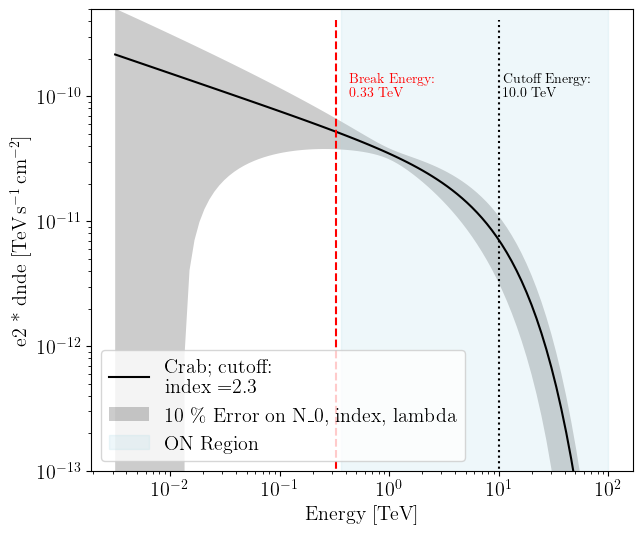

In [27]:
fig, ax = plt.subplots(1,1, figsize = (7,6))
colors = ['red', 'forestgreen', 'royalblue','purple']


energy_bounds = [0.003, 100] *u. TeV
energy_power = 2
crab_cutoff.plot(energy_bounds, 
                    label = f"Crab; cutoff:\n index ={crab_cutoff.parameters['index'].value}",
                   energy_power = energy_power,
                    color  = 'black')
label =  f"Crab; Smooth Break:\n index1 = {crab_break.parameters['index1'].value} \n "
label += f"index2 = {crab_break.parameters['index2'].value}"


yy = ax.get_ylim()
plt.text(crab_break.parameters['ebreak'].value + 0.1, 1e-10 , 
        f"Break Energy: \n{crab_break.parameters['ebreak'].value} TeV",
         color = 'red'
       )
ax.vlines( crab_break.parameters['ebreak'].value, yy[0], yy[1],
         label = "", color = 'red',
         linestyle = 'dashed',)
plt.text( 1/crab_cutoff.parameters['lambda_'].value + 1., 1e-10 , 
        f"Cutoff Energy: \n{1/crab_cutoff.parameters['lambda_'].value:.3} TeV",
         color = 'black'
       )

crab_cutoff.plot_error(energy_bounds, 
                    label ='10 \% Error on N_0, index, lambda',
                   energy_power = energy_power,
                    facecolor  = 'black')
ax.vlines( 1/crab_cutoff.parameters['lambda_'].value, yy[0], yy[1],
         label = f"",
          color = 'black',  linestyle = 'dotted', )

plt.fill_betweenx(ax.get_ylim(), emask[0].value,100, color = 'lightblue', alpha = 0.2,
                 label = "ON Region")

plt.ylim(1e-13, 5e-10)
plt.legend()



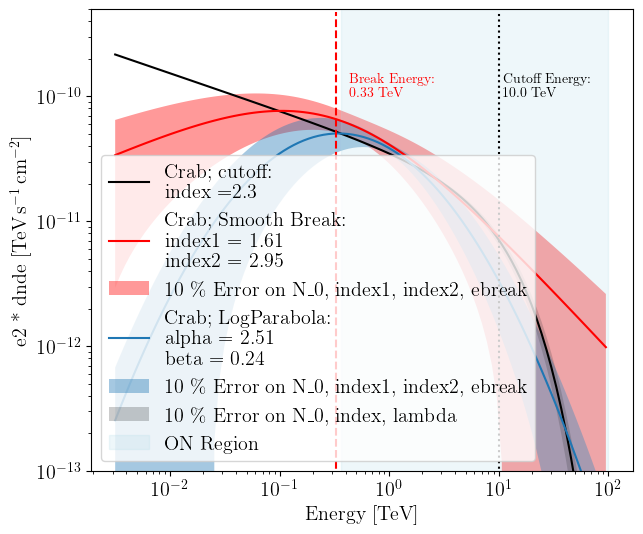

In [19]:
fig, ax = plt.subplots(1,1, figsize = (7,6))
colors = ['red', 'forestgreen', 'royalblue','purple']


energy_bounds = [0.003, 100] *u. TeV
energy_power = 2
crab_cutoff.plot(energy_bounds, 
                    label = f"Crab; cutoff:\n index ={crab_cutoff.parameters['index'].value}",
                   energy_power = energy_power,
                    color  = 'black')
label =  f"Crab; Smooth Break:\n index1 = {crab_break.parameters['index1'].value} \n "
label += f"index2 = {crab_break.parameters['index2'].value}"
crab_break.plot(energy_bounds, 
                    label =label,
                   energy_power = energy_power,
                    color  = 'red')

crab_break.plot_error(energy_bounds, 
                    label ='10 \% Error on N_0, index1, index2, ebreak',
                   energy_power = energy_power,
                    facecolor  = 'red', alpha = 0.4)

label =  f"Crab; LogParabola:\n alpha = {crab_log.parameters['alpha'].value} \n "
label += f"beta = {crab_log.parameters['beta'].value}"
crab_log.plot(energy_bounds, 
                    label =label,
                   energy_power = energy_power,
                    color  = 'tab:blue')

crab_log.plot_error(energy_bounds, 
                    label ='10 \% Error on N_0, index1, index2, ebreak',
                   energy_power = energy_power,
                    facecolor  = 'tab:blue', alpha = 0.4)

crab_cutoff.plot_error(energy_bounds, 
                    label ='10 \% Error on N_0, index, lambda',
                   energy_power = energy_power,
                    facecolor  = 'black')





yy = ax.get_ylim()
plt.text(crab_break.parameters['ebreak'].value + 0.1, 1e-10 , 
        f"Break Energy: \n{crab_break.parameters['ebreak'].value} TeV",
         color = 'red'
       )
ax.vlines( crab_break.parameters['ebreak'].value, yy[0], yy[1],
         label = "", color = 'red',
         linestyle = 'dashed',)
plt.text( 1/crab_cutoff.parameters['lambda_'].value + 1., 1e-10 , 
        f"Cutoff Energy: \n{1/crab_cutoff.parameters['lambda_'].value:.3} TeV",
         color = 'black'
       )

ax.vlines( 1/crab_cutoff.parameters['lambda_'].value, yy[0], yy[1],
         label = f"",
          color = 'black',  linestyle = 'dotted', )

plt.fill_betweenx(ax.get_ylim(), emask[0].value,100, color = 'lightblue', alpha = 0.2,
                 label = "ON Region")

plt.ylim(1e-13, 5e-10)
plt.legend()

fig.savefig("plots/2_input_spectra_crab_cases.pdf")

In [ ]:
with crab_log.parameters.restore_status():
    fig,axs = plt.subplots(3,1, figsize =(6, 7* 3))
    error = 0.1
    set_per_error(crab_log, "amplitude", error)
    set_per_error(crab_log, "alpha", error)
    set_per_error(crab_log, "beta", error)
   
    for i,p in enumerate(crab_log.parameters.free_parameters):
        with crab_log.parameters.restore_status():
            p.scan_n_sigma = 2
            ax = axs.flatten()[i]
            for v in p.scan_values:
                crab_log.parameters[p.name].value = v
                crab_log.plot(energy_bounds, 
                                label =f"{p.name}: {v:.3}",
                               energy_power = energy_power,
                               ax =ax)
    for ax in axs:
        crab_log.plot(energy_bounds, 
                                label =f"input",
                               energy_power = energy_power,
                               ax =ax, 
                               color = 'red')
        crab_log.plot_error(energy_bounds, 
                                label ='',
                               energy_power = energy_power,
                                facecolor  = 'red', 
                                     ax= ax)
        ax.legend()
        ax.fill_betweenx(ax.get_ylim(), emask[0].value,100, color = 'lightblue', alpha = 0.2,
                 label = "ON Region")
    fig.savefig("plots/crab_log_parameter_variations.pdf")

In [ ]:
with crab_break.parameters.restore_status():
    crab_break.parameters['beta'].frozen = False
    fig,axs = plt.subplots(5,1, figsize =(6, 7* 5))
    error = 0.1
    set_per_error(crab_break, "amplitude", error)
    set_per_error(crab_break, "index2", error)
    set_per_error(crab_break, "ebreak", error)
    set_per_error(crab_break, "index1", error)
    set_per_error(crab_break, "beta", error)
   
    for i,p in enumerate(crab_break.parameters.free_parameters):
        with crab_break.parameters.restore_status():
            p.scan_n_sigma = 2
            ax = axs.flatten()[i]
            for v in p.scan_values:
                crab_break.parameters[p.name].value = v
                crab_break.plot(energy_bounds, 
                                label =f"{p.name}: {v:.3}",
                               energy_power = energy_power,
                               ax =ax)
    for ax in axs:
        crab_break.plot(energy_bounds, 
                                label =f"input",
                               energy_power = energy_power,
                               ax =ax, 
                               color = 'red')
        crab_break.plot_error(energy_bounds, 
                                label ='',
                               energy_power = energy_power,
                                facecolor  = 'red', 
                                     ax= ax)
        ax.legend()
        ax.fill_betweenx(ax.get_ylim(), emask[0].value,100, color = 'lightblue', alpha = 0.2,
                 label = "ON Region")
    fig.savefig("plots/crab_break_parameter_variations.pdf")

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
colors = ['red', 'forestgreen', 'royalblue','purple']


energy_bounds = [0.3, 100] *u. TeV
energy_power = 2
pkscutoff_model.plot(energy_bounds,label = "LogParabola HESS 2015",
                      energy_power = energy_power,
                      color = colors[0])
pkscutoff_model.plot_error(energy_bounds, energy_power = energy_power,
                             facecolor = colors[0])

powerlaw_model.plot(energy_bounds,
                    label = "$\phi_{PL}$"+f"$(E; \Gamma = {pks_index}$)",
                   energy_power = energy_power, 
                    color = colors[1])

expcutpowerlaw_model.plot(energy_bounds, 
                        label = "$\phi_{ECPL}$"+f"$(E; E_c = {1/pks_lambda.value}\,$TeV)",
                         energy_power = energy_power,
                          color = colors[2])

gaussian_model.plot(energy_bounds, 
                    label = f"$\phi_G(E; \mu = {pks_mean.value}\,$TeV,$ \sigma = {pks_sigma.value}\,$TeV)",
                   energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = colors [3])

crab_spectral.plot(energy_bounds, 
                    label = f"Crab",
                   energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = 'black')

crab_break.plot(energy_bounds, 
                    label = f"Crab break",
                   energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = 'orange')



plt.legend()

plt.ylim(1e-14, 3e-10)
plt.fill_betweenx(ax.get_ylim(), emask[0].value,100, color = 'lightpink', alpha = 0.2)

fig.savefig("plots/2_input_spectra.pdf")

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
colors = ['red', 'forestgreen', 'royalblue','purple', "orange"]


energy_bounds = [0.3, 100] *u. TeV
energy_power = 2
alpha = 0.3
logparabola_model.plot(energy_bounds,label = "Crab - HESS 2015",
                      energy_power = energy_power,
                      color = colors[-1],
                     alpha = alpha)
logparabola_model.plot_error(energy_bounds, energy_power = energy_power,
                             facecolor = colors[-1],
                           alpha = alpha)


#pkscutoff_model.plot(energy_bounds,label = "PKS 2255-304 - LogParabola HESS 2005",
#                      energy_power = energy_power,
#                      color = colors[0],
#                     alpha = alpha)
#pkscutoff_model.plot_error(energy_bounds, energy_power = energy_power,
#                             facecolor = colors[0],
#                           alpha = alpha)

powerlaw_model.plot(energy_bounds,
                    label ="",
                   energy_power = energy_power, 
                    color = colors[1],
                    alpha = alpha)

expcutpowerlaw_model.plot(energy_bounds, 
                        label ="",
                         energy_power = energy_power,
                          color = colors[2],
                          alpha = alpha)

gaussian_model.plot(energy_bounds, 
                    label = "",
                   energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = colors [3],
                    alpha = alpha),

models  = [powerlaw_model,expcutpowerlaw_model,gaussian_model]
for m in models:
    m.parameters['amplitude'].value = 0.05 * crab_amplitude.value
    if 'amplitude_' in m.parameters.names:
        m.parameters['amplitude_'].value = 0.05 *  1.0000e-12
alpha = 1
powerlaw_model.plot(energy_bounds,
                    label = "$\phi_{PL}$"+f"$(E; \Gamma = {pks_index}$)",
                   energy_power = energy_power, 
                    color = colors[1],
                   alpha = alpha)

expcutpowerlaw_model.plot(energy_bounds, 
                        label = "$\phi_{ECPL}$"+f"$(E; E_c = {1/pks_lambda.value}\,$TeV)",
                         energy_power = energy_power,
                          color = colors[2],
                         alpha = alpha)

gaussian_model.plot(energy_bounds, 
                    label = f"$\phi_G(E; \mu = {pks_mean.value}\,$TeV, $ \sigma = {pks_sigma.value}\,$TeV)",
                    energy_power = energy_power,
                   linestyle = 'dashed', 
                    color  = colors [3],
                   alpha = alpha)
for m in models:
    m.parameters['amplitude'].value =  crab_amplitude.value
    if 'amplitude_' in m.parameters.names:
        m.parameters['amplitude_'].value =  1.0000e-12
plt.legend()

plt.ylim(1e-14, 3e-10)
plt.fill_betweenx(ax.get_ylim(), emask[0].value,100, color = 'lightpink', alpha = 0.2)

fig.savefig("plots/2_input_spectra_weak.pdf")

## MSH 15-52
### http://tevcat.uchicago.edu/?mode=1&showsrc=95

    Name: 	HESS J1514-591
	Source Class: 	PWN
	Identified Object: 	MSH 15-52
	R.A. (J2000): 	228.50 deg (15 13 59)
	Dec. (J2000): 	-59.16 deg (-59 09 40)
	Positional uncertainty: 	0.020 deg
	Spatial Model: 	3-Gaussian
	Size: 	0.145 +/- 0.026 deg
	Spectral Model: 	power law
	Integral Flux > 1 TeV: 	5.72e-12 +/- 4.17e-13 cm-2 s-1
	Pivot Energy, E0: 	1.54 TeV
	Diff. Flux at E0: 	2.58e-12 +/- 8.31e-14 cm-2 s-1 TeV-1
	Spectral Index: 	2.26 +/- 0.03 

In [ ]:
msh = SkyModel(spatial_model = GaussianSpatialModel(lon_0 = pks_pos.ra, 
                                  lat_0 = pks_pos.dec,
                                sigma = 0.145 *u.deg),
              spectral_model = PowerLawSpectralModel(amplitude = 2.58*1e-12 *u.Unit("1 / (TeV s cm2) "),
                                                    index = 2.26),
              name = "msh")
Models([msh]).write(f"model-msh.yaml", overwrite = True)

In [ ]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            try:
                plot_par(m[0].parameters[p[0]],
                 m[model_name].parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                        fmt = fmts[j],
                        markersize = markersize[j])
            except:
                pass

    plt.tight_layout()

labels = ['simulated', 'recovered pl', 'recovered ecpl']
fmts = ['o','x']
markersize = [6,10]

In [ ]:
dataset_pl = dataset_simulated.copy()
dataset_pl.models = powerlaw.copy()
dataset_ecpl = dataset_simulated.copy()
dataset_ecpl.models = expcutpowerlaw.copy()
dataset_plg = dataset_simulated.copy()
dataset_plg.models = gaussian.copy()


dataset_pl.counts = dataset_pl.npred()
dataset_ecpl.counts = dataset_ecpl.npred()
dataset_plg.counts = dataset_plg.npred()

#dataset_pl.fake(28)
#dataset_ecpl.fake(18)
#dataset_plg.fake(8)



In [ ]:
dataset_pl.write("dataset-simulated-pl.fits.gz", overwrite = True)
dataset_pl.models.write("model-pl.yaml", overwrite = True)
dataset_ecpl.write("dataset-simulated-ecpl.fits.gz", overwrite = True)
dataset_ecpl.models.write("model-ecpl.yaml", overwrite = True)
dataset_plg.write("dataset-simulated-plg.fits.gz", overwrite = True)
dataset_plg.models.write("model-plg.yaml", overwrite = True)


In [ ]:
%%time
fit = Fit()
fit.run([dataset_pl])
fit.run([dataset_ecpl])
fit.run([dataset_plg])

In [ ]:
dataset_pl.plot_residuals(kwargs_spatial={'vmax':0.51,
                                      'vmin':-0.51},
                      kwargs_spectral={'method' : 'diff/sqrt(model)'})

In [ ]:
models_list = [Models(powerlaw), dataset_pl.models, ]

pars =  pars = [('lon_0', 'lat_0'),('amplitude', 'index'),]
plot_source_par(0, pars)


In [ ]:
models_list = [Models(expcutpowerlaw), dataset_ecpl.models, ]
pars= [('lon_0', 'lat_0'),('amplitude', 'index'),
                ('lambda_', 'lambda_')]

plot_source_par(0, pars)


In [ ]:
models_list = [Models(gaussian), dataset_plg.models, ]
pars= [('lon_0', 'lat_0'),('amplitude_', 'index'),
                ('lambda_', 'lambda_'), ('mean', 'sigma')]

plot_source_par(0, pars)


In [ ]:
ee = dataset_pl.geoms['geom'].axes[0].center.value
labels = ['PL', 'ECPL', 'G']
datasets = [dataset_pl, dataset_ecpl, dataset_plg]
for i, d in enumerate(datasets):
    plt.plot(ee, 
         (d.counts* d.mask).data.sum(axis=2).sum(axis=1),
            label = labels[i])
plt.loglog()

In [ ]:
stat_sums = []
stat_sumsH0 = []

for d in datasets:
    stat_sums.append(d.stat_sum())

    with d.models.parameters.restore_status():
        d.models.parameters['amplitude'].value = 0
        try:
            d.models.parameters['amplitude_'].value = 0
        except:
            pass
        stat_sumsH0.append(d.stat_sum())
        
        
                     

In [ ]:
print(stat_sums)
print(stat_sumsH0)
print(np.array(stat_sumsH0) - np.array(stat_sums))
print(np.sqrt(np.array(stat_sumsH0) - np.array(stat_sums)))